# Import

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go

# DỮ LIỆU

## GIÁ LÚA

In [ ]:
df_rice = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Lua/gia_lua.csv', encoding='ISO-8859-1')
df_rice.tail()

,date,price
6274,5/11/2024,16000
6275,5/12/2024,16000
6276,5/13/2024,16000
6277,5/14/2024,16000
6278,5/15/2024,16000


In [ ]:
df_rice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6279 entries, 0 to 6278
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    6279 non-null   object
 1   price   6279 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 98.2+ KB


In [ ]:
df_rice['date'] = pd.to_datetime(df_rice['date'])
df_rice.set_index('date', inplace=True)

### Điền dữ liệu ngày còn thiếu

In [ ]:
idx = pd.date_range(df_rice.index.min(), df_rice.index.max())
df_rice = df_rice.reindex(idx)
df_rice.fillna(method='ffill', inplace=True)
df_rice.tail()

,price
2024-05-11,16000
2024-05-12,16000
2024-05-13,16000
2024-05-14,16000
2024-05-15,16000


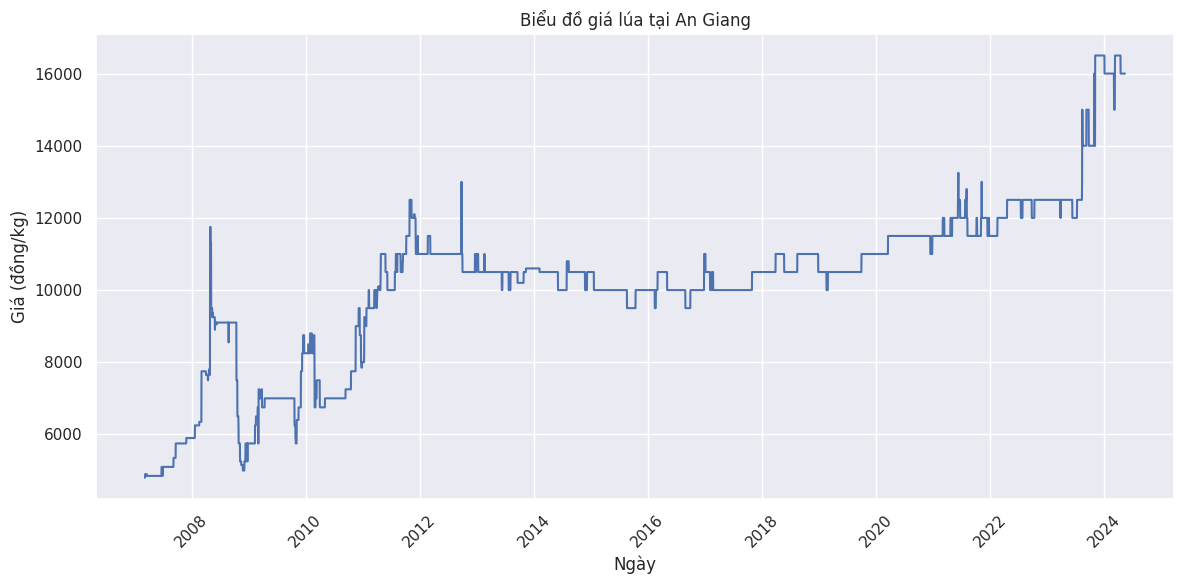

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_rice, x=df_rice.index, y='price')
plt.title('Biểu đồ giá lúa tại An Giang')
plt.xlabel('Ngày')
plt.ylabel('Giá (đồng/kg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## GIÁ XUẤT KHẨU

In [ ]:
df_rice_export = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Lua/xuat_khau_lua.csv', encoding='ISO-8859-1')
df_rice_export.head()

,date,Khoi luong (tan),Gia tri (USD),Gia tri (USD) / Khoi luong (tan)
0,11/1/2023,600481,400345332,666.707743
1,10/1/2023,635102,406762427,640.467873
2,9/1/2023,605410,377783375,624.012446
3,8/1/2023,921443,546405796,592.989253
4,7/1/2023,660738,362660136,548.871317


### Fill dữ liệu ngày bị thiếu

In [ ]:
df_rice_export['date'] = pd.to_datetime(df_rice_export['date'])
df_rice_export.set_index('date', inplace=True)

In [ ]:
idx = pd.date_range(df_rice_export.index.min(), df_rice_export.index.max())
df_gasoline = df_rice_export.reindex(idx)
df_gasoline.fillna(method='ffill', inplace=True)

### Merge dữ liệu xuất khẩu với giá lúa

In [ ]:
start_date = df_rice_export.index.min()
df_rice_filtered = df_rice.loc[start_date:]

df_merged_rice_export = pd.merge(df_rice_filtered, df_gasoline[['Gia tri (USD) / Khoi luong (tan)']], left_index=True, right_index=True, how='left')
df_merged_rice_export['Gia tri (USD) / Khoi luong (tan)'] = df_merged_rice_export['Gia tri (USD) / Khoi luong (tan)'].ffill()

print(df_merged_rice_export.tail())

            price  Gia tri (USD) / Khoi luong (tan)
2024-05-11  16000                        666.707743
2024-05-12  16000                        666.707743
2024-05-13  16000                        666.707743
2024-05-14  16000                        666.707743
2024-05-15  16000                        666.707743


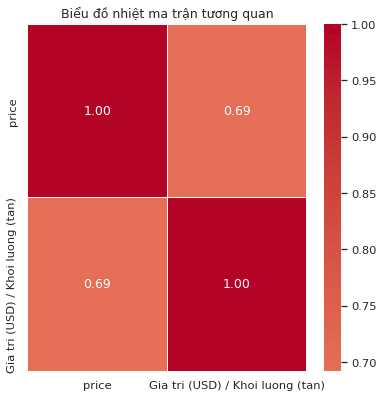

In [ ]:
correlation_matrix = df_merged_rice_export.corr()

plt.figure(figsize=(6, 6), dpi=75)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=.5, cmap='coolwarm', center=0)
plt.title('Biểu đồ nhiệt ma trận tương quan')
plt.show()

In [ ]:
# df_merged_rice_export.to_csv('gia_lua_xuat_khau.csv', index=True)

### Làm mịn dữ liệu

In [ ]:
df_merged_rice_export = df_merged_rice_export.rolling(window=30, min_periods=1).mean()

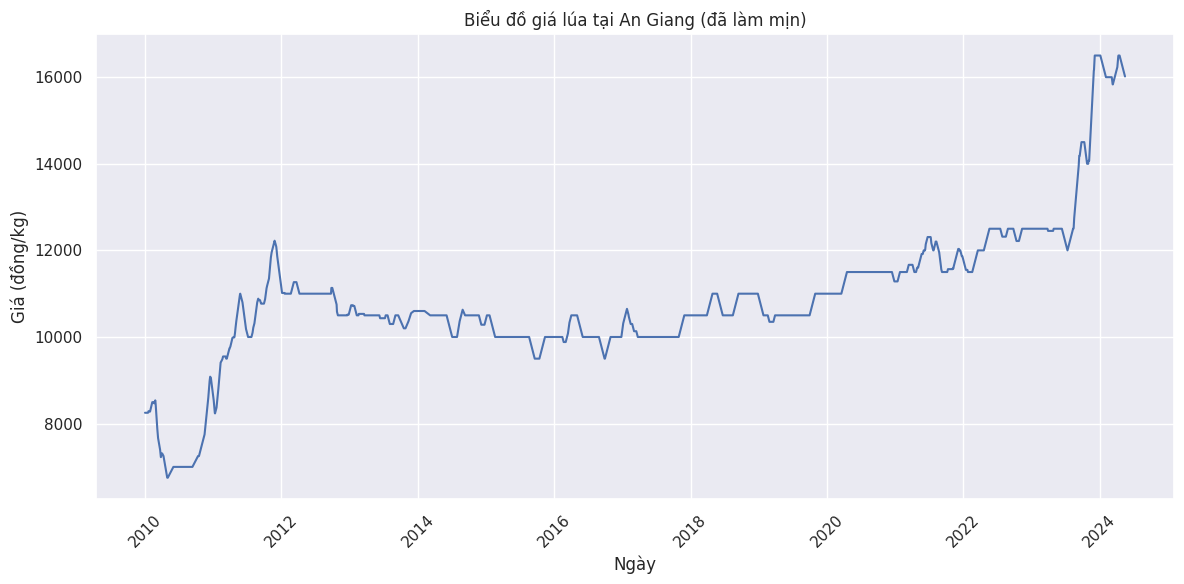

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_merged_rice_export, x=df_merged_rice_export.index, y='price')
plt.title('Biểu đồ giá lúa tại An Giang (đã làm mịn)')
plt.xlabel('Ngày')
plt.ylabel('Giá (đồng/kg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mô hình dự đoán

## Giá cà phê kết hợp giá xăng

### Xây dựng mô hình

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Preprocess data
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler_price.fit_transform(df_merged_rice_export[['price']])

scaler_export = MinMaxScaler(feature_range=(0, 1))
scaled_export = scaler_export.fit_transform(df_merged_rice_export[['Gia tri (USD) / Khoi luong (tan)']])

scaled_data = np.concatenate((scaled_price, scaled_export), axis=1)

In [ ]:
seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

In [ ]:
X.shape, y.shape

((5219, 30, 2), (5219,))

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)

Kích thước tập huấn luyện: (4175, 30, 2) (4175,)
Kích thước tập kiểm tra: (1044, 30, 2) (1044,)


In [ ]:
model = Sequential()
# model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(seq_length, 2)))
model.add(Bidirectional(LSTM(units=128), input_shape=(seq_length, 2)))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='tanh'))
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
66/66 [==============================] - 18s 103ms/step - loss: 0.0079
Epoch 2/50
66/66 [==============================] - 7s 103ms/step - loss: 6.6010e-04
Epoch 3/50
66/66 [==============================] - 5s 81ms/step - loss: 4.6935e-04
Epoch 4/50
66/66 [==============================] - 7s 110ms/step - loss: 4.0712e-04
Epoch 5/50
66/66 [==============================] - 5s 80ms/step - loss: 3.4767e-04
Epoch 6/50
66/66 [==============================] - 7s 111ms/step - loss: 3.1217e-04
Epoch 7/50
66/66 [==============================] - 5s 81ms/step - loss: 3.2097e-04
Epoch 8/50
66/66 [==============================] - 6s 86ms/step - loss: 2.5687e-04
Epoch 9/50
66/66 [==============================] - 7s 101ms/step - loss: 2.2269e-04
Epoch 10/50
66/66 [==============================] - 5s 81ms/step - loss: 2.1139e-04
Epoch 11/50
66/66 [==============================] - 7s 112ms/step - loss: 1.9526e-04
Epoch 12/50
66/66 [==============================] - 5s 81ms/step - los

### Dự đoán trên tập train

In [ ]:
train_predictions = model.predict(X_train)

131/131 [==============================] - 4s 21ms/step


In [ ]:
train_predictions = scaler_price.inverse_transform(train_predictions)
y_train = scaler_price.inverse_transform(y_train.reshape(-1, 1))

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mape = calculate_mape(y_train, train_predictions)

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAPE: {train_mape:.2f}%')

Training RMSE: 37.77
Training MAPE: 0.32%


In [ ]:
dates = df_merged_rice_export.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_train)], y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(train_predictions)], y=train_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá lúa trên tập huấn luyện (mô hình LSTM, dữ liệu giá lúa và giá xuất khẩu)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Dự đoán trên tập test

In [ ]:
test_predictions = model.predict(X_test)

33/33 [==============================] - 1s 22ms/step


In [ ]:
test_predictions = scaler_price.inverse_transform(test_predictions)
y_test = scaler_price.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mape = calculate_mape(y_test, test_predictions)

print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Testing MAPE: {test_mape:.2f}%')

Testing RMSE: 54.42
Testing MAPE: 0.29%


In [ ]:
dates = df_merged_rice_export.index.tolist()
test_dates = dates[-len(y_test):]

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=test_dates, y=test_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá lúa trên tập kiểm tra (mô hình LSTM, dữ liệu giá lúa và giá xuất khẩu)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Đánh giá kết quả

In [ ]:
results = pd.DataFrame({
    '': ['Train', 'Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAPE (%)': [train_mape, test_mape]
})
results = results.round(2)

print(results)

           RMSE  MAPE (%)
0  Train  37.77      0.32
1   Test  54.42      0.29


### Lưu mô hình

In [ ]:
# model.save('BiLSTM_gia_lua_xuat_khau.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

